In [42]:
import ete3
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

ncbi = ete3.NCBITaxa()

In [2]:
%cd /work/clusterEvo/new_tests/archaea/

/work/clusterEvo/new_tests/archaea


In [3]:
tree = ete3.Tree('concat_tree/C20/cluster_4-C60.taxid.treefile', format=1)

In [4]:
cltree = ete3.ClusterTree(tree.write(format=0), 
                        text_array='cluster_genome_occurrence.tab')


In [7]:
for node, clnode in zip(tree.traverse(), cltree.traverse()):
    if not node.is_leaf():
        clnode.name = node.name

In [11]:
lineages = pd.DataFrame()
for taxid in cltree.get_leaf_names():
    try:
        taxid_lineage = ncbi.get_lineage(int(taxid))
    except ValueError:
        missing_taxids.add(taxid)
    else:
        tmp_lineage = pd.Series( {rank:taxon
                                  for taxon, rank in ncbi.get_rank( taxid_lineage ).items()} )
        tmp_lineage.name = taxid
        lineages    = lineages.append(tmp_lineage)

lineages.drop(columns='no rank', inplace=True)

In [12]:
for node in cltree.traverse():
    if node.is_leaf():
        full_name = ncbi.translate_to_names([int(node.name)])[0]
        full_name = full_name.replace('Candidatus', 'Ca.')
        node.add_feature('full_name', full_name)
    else:
        if not node.name:
            continue
        for value, support_type in zip(node.name.split('/'), ['ufboot', 'alrt']):
            node.add_feature(support_type, float(value))

In [13]:
dpann = '1805424 2594798 228908 1974404'.split()
dpann_clade = cltree.get_common_ancestor(dpann)
cltree.set_outgroup( dpann_clade )

cltree.ladderize(1)

42

In [14]:
for leaf in dpann_clade.iter_leaves():
    leaf.add_feature('clade', 'dpann')

eury_clade = cltree.get_common_ancestor(['186497', '304371'])
for leaf in eury_clade.iter_leaves():
    leaf.add_feature('clade', 'euryarchaea')
    
asgard_clade = cltree.get_common_ancestor(['2012493', '2053489'])
for leaf in asgard_clade.iter_leaves():
    leaf.add_feature('clade', 'asgard')
    
thaum_clade = cltree.get_common_ancestor(['1198115', '436308'])
for leaf in thaum_clade.iter_leaves():
    leaf.add_feature('clade', 'thaumarchaea')
    
crenar_clade = cltree.get_common_ancestor(['368408', '272557'])
for leaf in crenar_clade.iter_leaves():
    leaf.add_feature('clade', 'crenarchaea')

kor_leaf = next(cltree.iter_search_nodes(name='374847'))
kor_leaf.add_feature('clade', 'korarchaea')

In [15]:
leaf_colors = dict(euryarchaea =(87,  132,  42),
                   asgard      =(208, 156,  95),
                   thaumarchaea=(214, 117, 169),
                   crenarchaea =( 82, 104, 204),
                   korarchaea  =( 82, 171, 204),
                   dpann       =(163,  51,  66))

nameFaces = {clade:ete3.AttrFace("full_name", 
                                 fgcolor='#%02x%02x%02x' % rgb, 
                                 fsize  =15) 
             for clade, rgb in leaf_colors.items()}

In [55]:
def get_color_gradient(self):
    from PyQt5 import QtGui
    import matplotlib.colors as colors
    import matplotlib.cm as cmx

    cNorm  = colors.Normalize(vmin=0, vmax=1)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=plt.get_cmap(self.colorscheme))
    color_scale = []
    for scale in np.linspace(0, 1, 201):
#         hex_color = '#%02x%02x%02x' %scalarMap.to_rgba(scale)[:3]
        [r,g,b,a] = scalarMap.to_rgba(scale, bytes=True)
        color_scale.append( QtGui.QColor( r, g, b, a ) )

    return color_scale

ete3.ProfileFace.get_color_gradient = get_color_gradient

In [64]:
nameFace    = ete3.AttrFace("full_name", fsize=10)
supportFace = ete3.AttrFace("support",   fsize=10)

def myLayout(node):
    mapping = ete3.ProfileFace(max_v      =1, 
                               min_v      =0.01, 
                               center_v   =0.5,
                               height     =20,
                               width      =300,
                               style      ="heatmap", 
                               colorscheme='RdBu_r')

    node.img_style['size'] = 0

    if node.is_leaf():
        ete3.add_face_to_node(mapping, node, 1, aligned=True)

        ete3.add_face_to_node(nameFaces[node.clade], node, 2, aligned=True)
    elif node.is_root():
        pass
    else:
        if not 'ufboot' in node.features:
            pass
        elif node.ufboot >= 95 and node.alrt >= 80:
            node.img_style['size']    = 7
            node.img_style['fgcolor'] = '#33993B'
        elif node.ufboot >= 95 or node.alrt >= 80:
            node.img_style['size']    = 7
            node.img_style['fgcolor'] = '#E9DD34'

In [65]:
treeStyle                        = ete3.TreeStyle()
treeStyle.layout_fn              = myLayout
treeStyle.show_leaf_name         = False
treeStyle.draw_guiding_lines     = True
treeStyle.branch_vertical_margin = 2

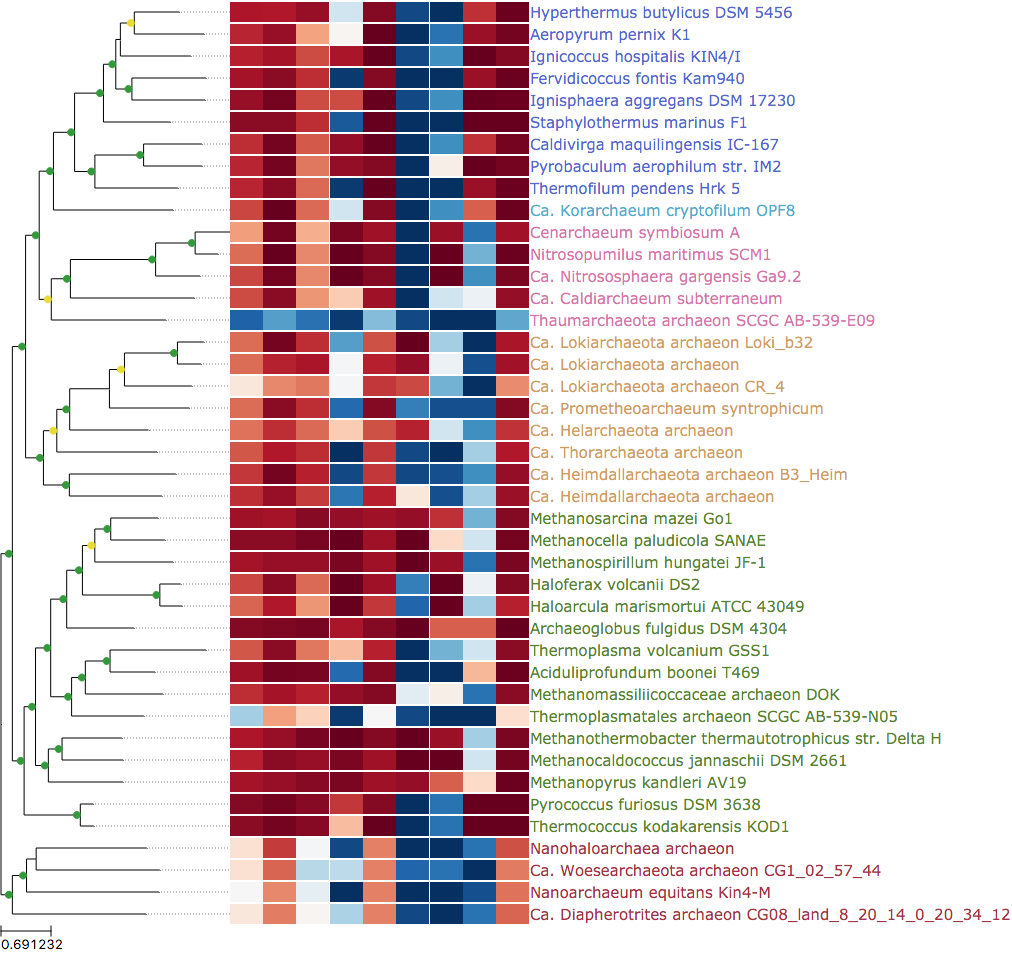

In [70]:
cltree.render('%%inline', 
              dpi       =100,
              tree_style=treeStyle)

In [67]:
cltree.render('cluster4.C60.tree_and_heatmap.svg', 
            dpi       =1_200,
            tree_style=treeStyle);